In [91]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import decomposition

In [92]:
# Constants
NORMAL = 0
INTERICTAL = 1
ICTAL = 2

# Creating file_list for data
data_path = "C:\\Users\\camer\\Desktop\\Neurovigil\\EEG_Data\\"
folder_names = ['Z_normal', 'O_normal', 'N_interictal', 
                'F_interictal', 'S_ictal']
state_label = [NORMAL]*200 + [INTERICTAL]*200 + [ICTAL]*100
label_list = [data_path + "Z_normal" + "\\*.txt",
             data_path + "O_normal" + "\\*.txt",
             data_path + "N_interictal" + "\\*.txt",
             data_path + "F_interictal" + "\\*.txt",
             data_path + "S_ictal" + "\\*.txt"]
file_list = []
for label in label_list:
    file_list += glob.glob(label)
    
# Pulling data
data = [[]]*500
i = 0
for file in file_list:
    arr = open(file).read()
    data[i] = ([int(x) for x in arr.split()])
    i += 1
data = np.array(data)
data_transpose = np.transpose(data)

In [93]:
# Variable/data organization
x = data
y = state_label
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [94]:
# Using PCA to first decide where %95 of the data is, then fit to that %95
def my_preprocessing(data):
    data = preprocessing.scale(data)
    pca1 = decomposition.PCA()
    pca1.fit(data)
    minimum_data = 0
    components = 0
    for i in pca1.explained_variance_ratio_:
        minimum_data += i
        components += 1
        if minimum_data > 0.99:
            print("minimum_data = " + str(minimum_data) + "\nafter x components:" + str(components))
            break
    pca = decomposition.PCA(n_components = components)
    data = pca.fit_transform(data)
    return data

In [95]:
# Create, train, test an SVC Model
def svc_model(x_train, y_train, x_test, y_test):
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
    classifier.fit(x_train, y_train)
    y_test_preds = classifier.predict(x_test)

    fpr, tpr, roc_auc = roc_auc_calc(n_classes, y_test, y_test_preds)
    plot_roc(fpr, tpr, roc_auc, 'Receiver Operating Characteristic: SVC Model')

In [96]:
# Create, train, test a Decision Tree Model
def decision_tree_model(x_train, y_train, x_test, y_test, iterations=1):
    decision_tree = DecisionTreeClassifier(random_state=0)
    for _ in range(iterations):
        decision_tree.fit(x_train, y_train)
        importances = decision_tree.feature_importances_
        y_test_preds = decision_tree.predict(x_test)  
        fpr, tpr, roc_auc = roc_auc_calc(n_classes, y_test, y_test_preds)
        predictions = decision_tree.predict(x_test)
    plot_roc(fpr, tpr, roc_auc, 'Receiver Operating Characteristic: Decision Tree Model')
    return importances, predictions

In [97]:
# Compute ROC curve and ROC area for a general model
def roc_auc_calc(n_classes, y_test, y_test_preds):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

In [98]:
# Plot an ROC curve
def plot_roc(fpr, tpr, roc_auc, graph_title):
    #Plotting ROC curve for SVC Model
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(graph_title)
    plt.legend(loc="upper left")
    plt.show()

minimum_data = 0.9900207905695272
after x components:248


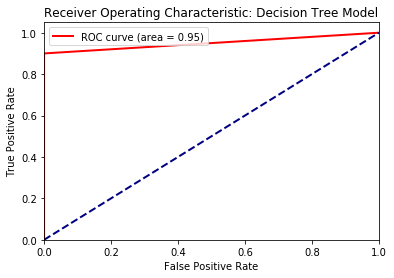

In [99]:
data = my_preprocessing(data)
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=1)
importances, predictions = decision_tree_model(x_train, y_train, x_test, y_test)


#for i in range(4):
#    deleted = 0
#    new_y = y
#    new_data = data
#    for i in range(np.size(importances)):
#        if importances[i] == 0:
#            new_data = np.delete(new_data, i - deleted, 1)
#            new_y = np.delete(new_y, i - deleted, 0)
#            deleted += 1
#    
#    new_data = my_preprocessing(new_data)
#    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=1)
#    importances, predictions = decision_tree_model(x_train, y_train, x_test, y_test, )
#    print(np.size(new_data))